In [1]:
import numpy
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
import numpy as np

In [2]:
#Setting time constraint

start = dt.datetime(2015,1, 1)
end = dt.datetime.now()
start, end

(datetime.datetime(2015, 1, 1, 0, 0),
 datetime.datetime(2025, 6, 27, 17, 38, 55, 781395))

In [3]:
ticker = 'PLTR'

data = yf.download(f'{ticker}', start, end)
day = np.arange(1, len(data) + 1)
data['day'] = day
data.drop(columns=['Volume'], inplace = True)
data = data[['day', 'Open', 'High', 'Low', 'Close']]

# Flatten MultiIndex columns to just 'Open', 'High', 'Low', 'Close'
data.columns = data.columns.droplevel(1)  # Drop 'Price'
data.columns.name = None                  # Drop 'Ticker'


data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,day,Open,High,Low,Close
Date,,,,,
2020-09-30,1,10.00,11.41,9.11,9.50
2020-10-01,2,9.69,10.10,9.23,9.46
2020-10-02,3,9.06,9.28,8.94,9.20
2020-10-05,4,9.43,9.49,8.92,9.03
2020-10-06,5,9.04,10.18,8.90,9.90


In [4]:
#Adding moving averages into the dataframe
data['10-day'] = data['Close'].rolling(10).mean()
data['20-day'] = data['Close'].rolling(20).mean()

#Identify starting day of the moving average with a rough guess - in this case its day '20'
data[15:30]

#This implies some lookahead information (calculating moving average on closing price for 20 days we need to wait until stock closes on the 20th day to begin calc)
#Model believes we already know closing price as day starts.
data['10-day'] = data['Close'].rolling(10).mean().shift()
data['20-day'] = data['Close'].rolling(20).mean().shift()
data[15:30]

#Now it says the 20  day '21'
data.dropna(inplace=True)
data.head()


,day,Open,High,Low,Close,10-day,20-day
Date,,,,,,,
2020-10-28,21,10.66,10.985,10.10,10.85,9.707,9.6735
2020-10-29,22,10.90,11.100,10.56,10.75,9.858,9.7410
2020-10-30,23,10.61,10.680,9.85,10.13,9.942,9.8055
2020-11-02,24,10.23,10.570,10.23,10.54,9.984,9.8520
2020-11-03,25,10.57,10.940,10.44,10.50,10.081,9.9275


In [5]:
#Adding trade signals
data['signal'] = np.where(data['10-day'] > data['20-day'], 1, 0)
data['signal'] = np.where(data['10-day'] < data['20-day'], -1, data['signal'])
data.dropna(inplace = True)
data.head()

,day,Open,High,Low,Close,10-day,20-day,signal
Date,,,,,,,,
2020-10-28,21,10.66,10.985,10.10,10.85,9.707,9.6735,1
2020-10-29,22,10.90,11.100,10.56,10.75,9.858,9.7410,1
2020-10-30,23,10.61,10.680,9.85,10.13,9.942,9.8055,1
2020-11-02,24,10.23,10.570,10.23,10.54,9.984,9.8520,1
2020-11-03,25,10.57,10.940,10.44,10.50,10.081,9.9275,1


In [6]:
#Calculate log returns -> system return depends on long/short signal (1, -1)
#Added a difference column to indicate when we change signal (long->short = -2) (short->long = +2)
data['log_returns'] = np.log(data['Close']).diff()

#System return shows the return depending on the signal (*1, or *-1)
data['system_return'] = data['signal'] * data['log_returns']
data['entry'] = data.signal.diff()
data.head()

,day,Open,High,Low,Close,10-day,20-day,signal,log_returns,system_return,entry
Date,,,,,,,,,,,
2020-10-28,21,10.66,10.985,10.10,10.85,9.707,9.6735,1,NaN,NaN,NaN
2020-10-29,22,10.90,11.100,10.56,10.75,9.858,9.7410,1,-0.009259,-0.009259,0.0
2020-10-30,23,10.61,10.680,9.85,10.13,9.942,9.8055,1,-0.059404,-0.059404,0.0
2020-11-02,24,10.23,10.570,10.23,10.54,9.984,9.8520,1,0.039676,0.039676,0.0
2020-11-03,25,10.57,10.940,10.44,10.50,10.081,9.9275,1,-0.003802,-0.003802,0.0


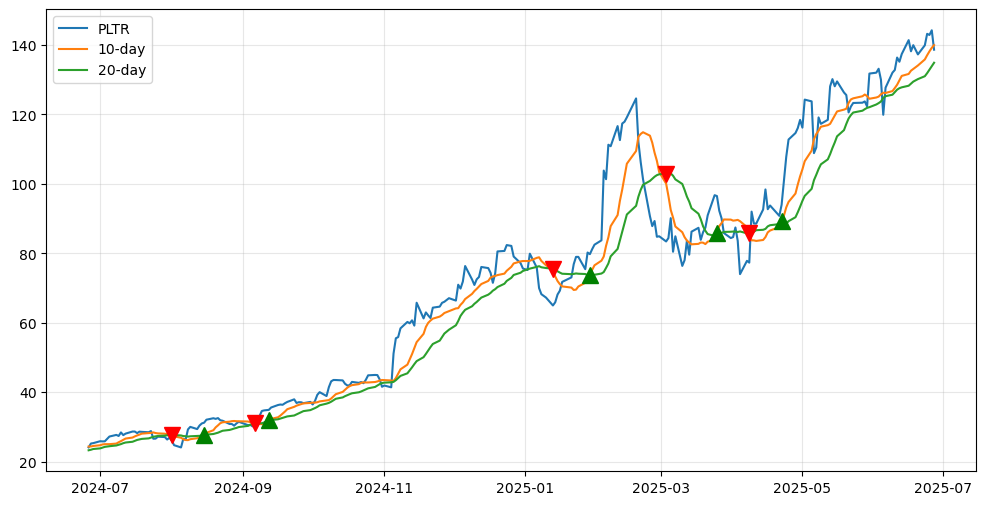

In [7]:
#Visualising 

#Setting basic parameters for all graphs
plt.rcParams['figure.figsize'] = 12, 6

#Introducing grid
plt.grid(True, alpha = .3)

#Plotting closing prices of the last trading year  (approx 252 days)
plt.plot(data.iloc[-252:]['Close'], label = 'PLTR')

#Plotting moving average data
plt.plot(data.iloc[-252:]['10-day'], label = '10-day')
plt.plot(data.iloc[-252:]['20-day'], label = '20-day')


plt.plot(data[-252:].loc[data.entry == 2].index, data[-252:]['10-day'][data.entry == 2], '^',
         color = 'g', markersize = 12)
plt.plot(data[-252:].loc[data.entry == -2].index, data[-252:]['20-day'][data.entry == -2], 'v',
         color = 'r', markersize = 12)

plt.legend(loc=2);

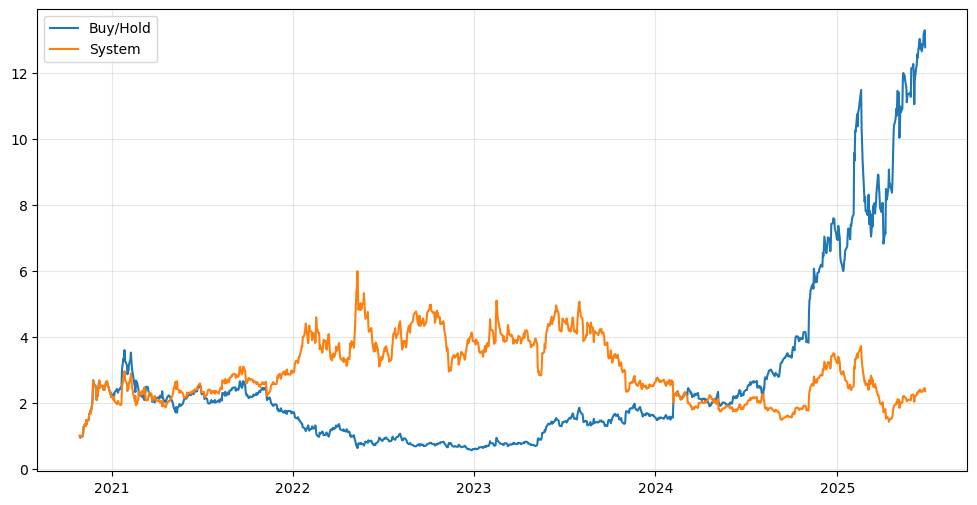

In [8]:
plt.plot(np.exp(data['log_returns']).cumprod(), label='Buy/Hold')
plt.plot(np.exp(data['system_return']).cumprod(), label='System')
plt.legend(loc=2)
plt.grid(True, alpha=.3)

In [9]:
#Conclusion

#System manages downside and flat markets well, outperforming buy-and-hold.
#During Palantir's strong bullish trends, the model lags due to possibly frequent trading, or conservative exits.
#Improved with risk management implications
#Shows a classic trade-off between trend-following vs active management
